## Install and run optuna

In [ ]:
!pip install cupy-cuda110
!pip install -U py-boost
!pip install optuna

## Imports

In [3]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import cupy as cp
import py_boost

import optuna
import numpy as np
import pandas as pd

from copy import deepcopy

from sklearn.model_selection import KFold, train_test_split

# simple case - just one class is used
from py_boost import GradientBoosting 
from py_boost.gpu.losses import Loss, Metric

from utils import *

import gc

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
sns.set_style("whitegrid")


In [4]:
N_TRIALS = 20
LR_TUNE = 0.05
LR_REFIT = 0.05

NUM_TREES = 2000
NUM_TREES_REFIT = 2000
ES = 100

N_STEPS_PLOT = 300
SEED = 42


## ALLSTATE dataset

In [7]:
%%time

data = pd.read_csv('./train_allstate.csv')
data.drop('id', axis=1, inplace=True)

for col in [x for x in data.columns if x.startswith('cat')]:
    data[col], _ = pd.factorize(data[col])
    
data = data.astype({x: np.float32 for x in data.columns})
y = data['loss'].values
X = data.drop('loss', axis=1).values

del data
gc.collect()

CPU times: user 8.68 s, sys: 8.39 s, total: 17.1 s
Wall time: 18.7 s


0

In [8]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)

del X, y
gc.collect()

print(X_val.shape, X_test.shape)

(30131, 130) (37664, 130)


## HOUSE PRICES dataset

In [60]:
%%time

data = pd.read_csv('./train_house_prices.csv')
data.drop('Id', axis=1, inplace=True)
data.dropna(axis=1, inplace=True)

for col in [x for x in data.columns if data[x].dtype == 'O']:
    data[col], _ = pd.factorize(data[col])
    
data = data.astype({x: np.float32 for x in data.columns})
y = data['SalePrice'].values
X = data.drop('SalePrice', axis=1).values

del data
gc.collect()

CPU times: user 245 ms, sys: 1.01 ms, total: 246 ms
Wall time: 246 ms


0

In [61]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)

del X, y
gc.collect()

print(X_val.shape, X_test.shape)

(234, 60) (292, 60)


## LIFE EXPECTANCY dataset

In [74]:
%%time

data = pd.read_csv('./Life_Expectancy_Data.csv')
data.dropna(axis=0, inplace=True)

for col in [x for x in data.columns if data[x].dtype == 'O']:
    data[col], _ = pd.factorize(data[col])
    
data = data.astype({x: np.float32 for x in data.columns})
y = data['Life expectancy '].values
X = data.drop('Life expectancy ', axis=1).values

del data
gc.collect()

CPU times: user 184 ms, sys: 2 ms, total: 186 ms
Wall time: 185 ms


30

In [75]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)

del X, y
gc.collect()

print(X_val.shape, X_test.shape)

(264, 21) (330, 21)


## CAR PRICE dataset

In [80]:
%%time

data = pd.read_csv('./car_price_prediction.csv')
data.drop('ID', axis=1, inplace=True)
data.dropna(axis=0, inplace=True)

for col in [x for x in data.columns if data[x].dtype == 'O']:
    data[col], _ = pd.factorize(data[col])
    
data = data.astype({x: np.float32 for x in data.columns})
y = data['Price'].values
X = data.drop('Price', axis=1).values

del data
gc.collect()

CPU times: user 352 ms, sys: 1.99 ms, total: 354 ms
Wall time: 360 ms


20

In [81]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)

del X, y
gc.collect()

print(X_val.shape, X_test.shape)

(3078, 16) (3848, 16)


## The custom losses

In [62]:
def get_objective(loss, **params):

    def objective(trial, params=params):
        
        params = {x: trial.suggest_float(x, *params[x]) for x in params}
        
        model = GradientBoosting(
            loss=loss(**params), 
            metric=CustomMAEMetric(),
            ntrees=NUM_TREES, 
            lr=LR_TUNE,
            es=ES, 
            lambda_l2 = trial.suggest_float("lambda_l2", 1., 20.),
            max_depth=trial.suggest_int("max_depth", 4, 8),
            subsample=trial.suggest_float("subsample", 0.5, 1),
            colsample=trial.suggest_float("colsample", 0.5, 1),
            verbose=100, 

        )
        model.fit(X_train, y_train, eval_sets=[{'X': X_val, 'y': y_val},])
        y_pred = model.predict(X_val)[:, 0]

        return (np.abs(y_val - y_pred)).mean()
    
    return objective


def model_refit(X, y, X_val, y_val, X_test, y_test, loss, params):
    
    params = deepcopy(params)
    fit_params = {}
    
    for k in ['lambda_l2', 'max_depth', 'subsample', 'colsample']:
        fit_params[k] = params.pop(k)
    
    model = GradientBoosting(
        loss(**params), 
        metric=CustomMAEMetric(),
        ntrees=NUM_TREES,
        es=ES,
        lr = LR_REFIT,
        verbose=100,
        **fit_params
    )

        
    model.fit(X, y, eval_sets=[{'X': X_val, 'y': y_val},])
    
    y_pred = model.predict(X_test)[:, 0]
    test_score = np.abs(y_test - y_pred).mean()
    
    return model, test_score

## EVAL

In [82]:
LOSSES = {
    
    'PSEUDO_HUBER': (PseudoHuberLoss, {'delta': [1, 20]}, ),
    'HUBER': (CustomHuberLoss, {'delta': [1, 20]}, ),
    'MSLE': CustomMSLELoss,
    'MAE': CustomMAELoss,
    'LogCosh': CustomLogCoshLoss,
    
}

In [ ]:
%%time

test_scores = {}
val_scores  = {}
eval_hist   = {}

for key in LOSSES:
    
    print(f"PARAM TUNING FOR {key} LOSS")
    
    loss = LOSSES[key]
    
    if type(loss) is tuple:
        loss, params = loss
    else:
        params = {}
    
    # find best params
    study = optuna.create_study(
    direction='minimize'
    )

    study.optimize(
        get_objective(loss, **params), 
        n_trials=N_TRIALS, 
        gc_after_trial=True,
    )
    
    # evaluate on test set
    print(f"REFIT FOR {key} LOSS")
    
    model, score = model_refit(X_train, y_train, X_val, y_val, X_test, y_test, loss, study.best_params)
    eval_hist[key] = [x[0] for x in model.history]
    val_scores[key] = min(eval_hist[key])
    test_scores[key] = score
    
    print(f"RESULTS FOR {key}: Val score {val_scores[key]}, Test score {test_scores[key]}")
    
    study.trials_dataframe().to_csv(f'{key}_trials.csv')

## Plots

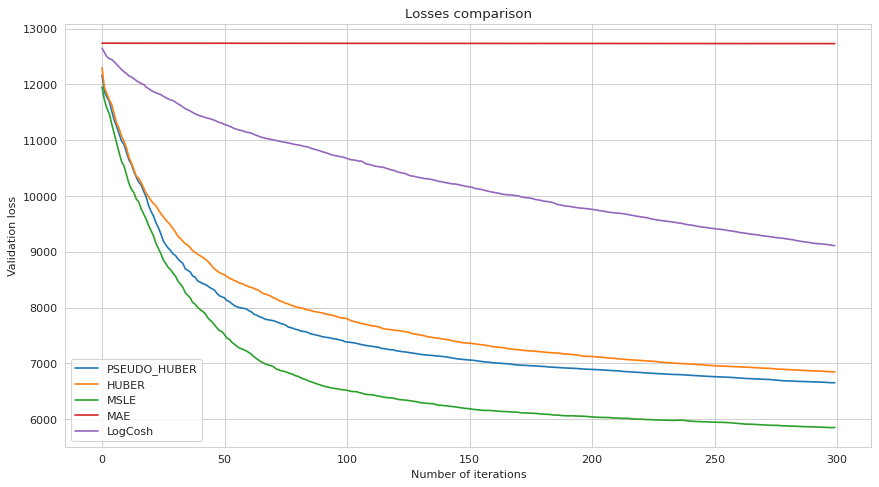

In [84]:
figure(figsize=(13, 7), dpi=80)

legends = ['LogCosh', 'Huber', 'MAE', 'MSLE', 'Pseudo Huber']

plt.xlabel('Number of iterations')
plt.ylabel('Validation loss')
plt.title('Losses comparison')

for key in eval_hist:
    plt.plot(eval_hist[key][:N_STEPS_PLOT], label=key)
    
plt.legend()

In [85]:
test_scores

{'PSEUDO_HUBER': 5871.8906,
 'HUBER': 5941.078,
 'MSLE': 5868.4937,
 'MAE': 12690.63,
 'LogCosh': 6892.3296}